In [34]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import sklearn

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.datasets import make_moons
from collections import Counter
from sklearn.model_selection import train_test_split

from matplotlib.ticker import (MultipleLocator,
                              FormatStrFormatter,
                              AutoMinorLocator)

In [2]:
# Some Basic Directories for housekeeping
# set location of input files:
inpDir = os.path.join( '..', 'input')

outDir = os.path.join('..', 'output')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

CMAP = plt.cm.rainbow
plt.set_cmap(CMAP);
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

TEST_SIZE = 0.2

NOISE = 0.1
N_SAMPLE = 1000
ALPHA = 0.001

<Figure size 640x480 with 0 Axes>

In [3]:
# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large',
          'savefig.dpi': 75,
          'image.cmap': 'jet',
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }


plt.rcParams.update(params)

'''plt.rc('axes', prop_cycle=(
    cycler('color', mglearn.plot_helpers.cm_cycle.colors) +
    cycler('linestyle', ['-', '-', "--", (0, (3, 3)), (0, (1.5, 1.5))])))
'''
np.set_printoptions(precision=3, suppress=True)

pd.set_option("display.max_columns", 8)
pd.set_option('display.precision', 2)

__all__ = ['np', 'display', 'plt', 'pd', 'sklearn', 'seaborn']

In [4]:
boston_housing = os.path.join(inpDir, 'boston_house_price.csv')

data_df = pd.read_csv(boston_housing)

data_df.head()

,CRIM,ZN,INDUS,CHAS,...,PTRATIO,B,LSTAT,MEDV
0,6.32e-03,18.0,2.31,0.0,...,15.3,396.90,4.98,24.0
1,2.73e-02,0.0,7.07,0.0,...,17.8,396.90,9.14,21.6
2,2.73e-02,0.0,7.07,0.0,...,17.8,392.83,4.03,34.7
3,3.24e-02,0.0,2.18,0.0,...,18.7,394.63,2.94,33.4
4,6.91e-02,0.0,2.18,0.0,...,18.7,396.90,5.33,36.2


In [5]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.61,8.60,6.32e-03,0.08,0.26,3.68,88.98
ZN,506.0,11.36,23.32,0.00e+00,0.00,0.00,12.50,100.00
INDUS,506.0,11.14,6.86,4.60e-01,5.19,9.69,18.10,27.74
CHAS,506.0,0.07,0.25,0.00e+00,0.00,0.00,0.00,1.00
NOX,506.0,0.55,0.12,3.85e-01,0.45,0.54,0.62,0.87
RM,506.0,6.28,0.70,3.56e+00,5.89,6.21,6.62,8.78
AGE,506.0,68.57,28.15,2.90e+00,45.02,77.50,94.07,100.00
DIS,506.0,3.80,2.11,1.13e+00,2.10,3.21,5.19,12.13
RAD,506.0,9.55,8.71,1.00e+00,4.00,5.00,24.00,24.00
TAX,506.0,408.24,168.54,1.87e+02,279.00,330.00,666.00,711.00


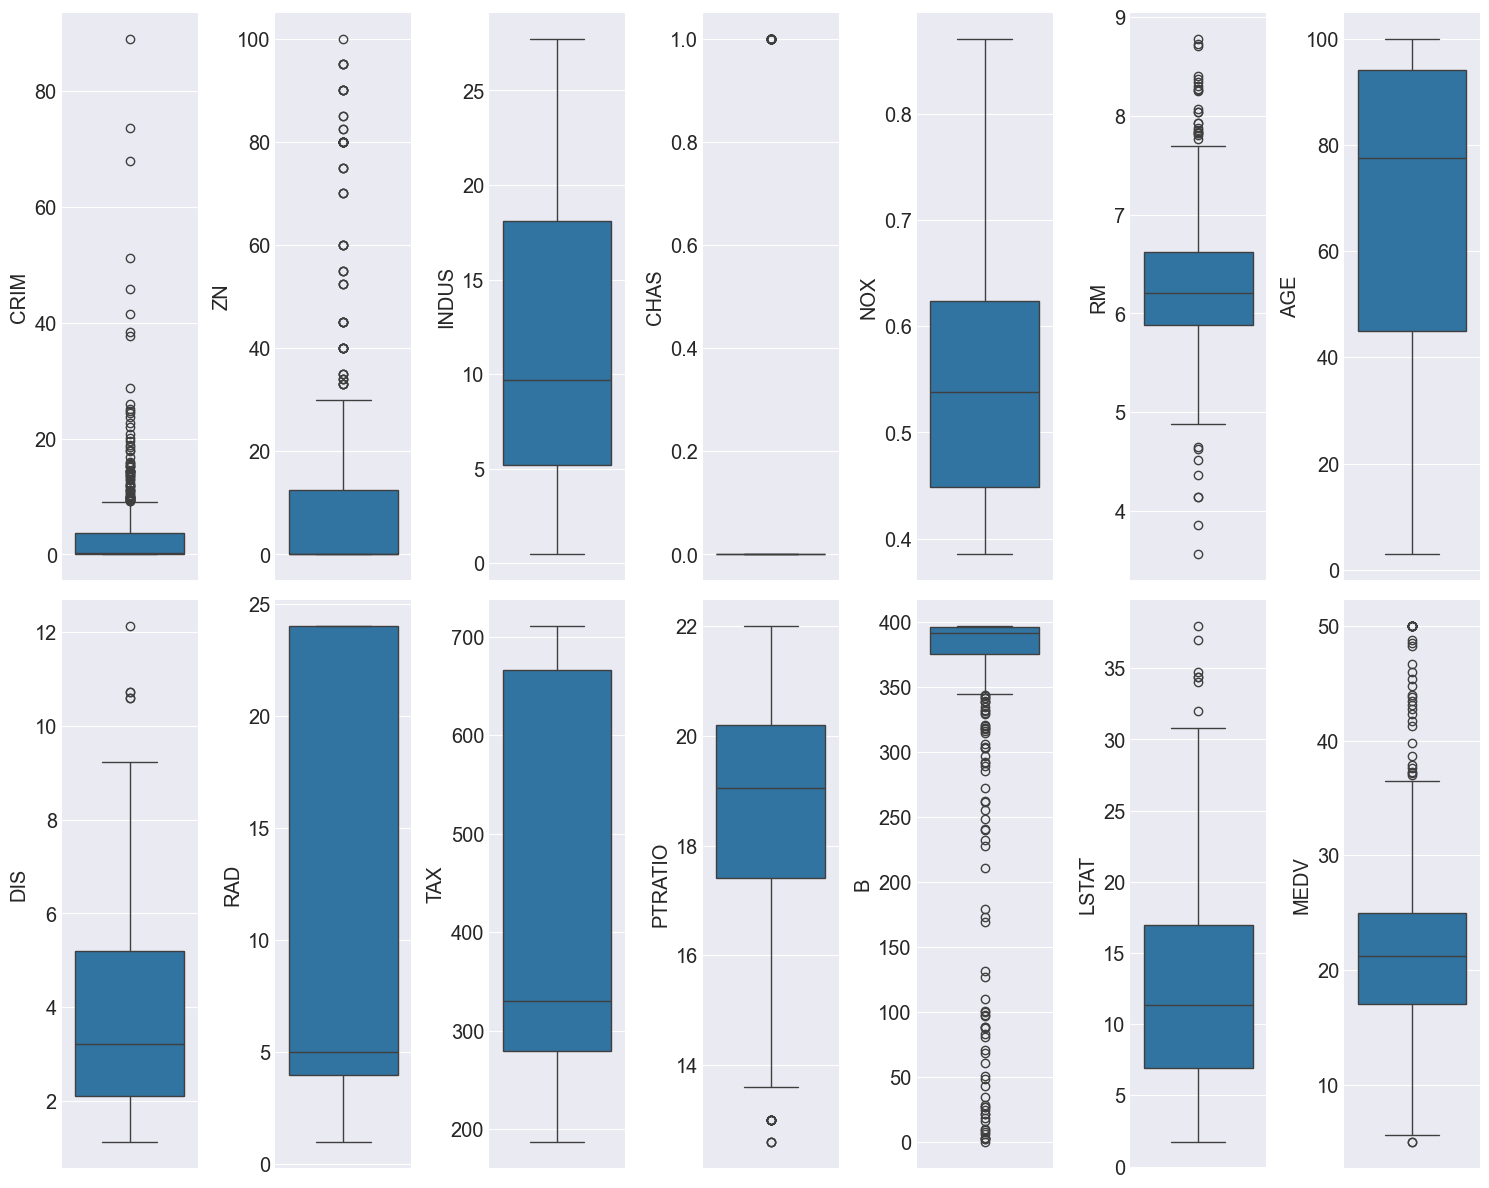

In [6]:
fig, axes = plt.subplots(ncols = 7, nrows = 2, figsize = (15,12))

axes = axes.ravel()

for count, col in enumerate(data_df.columns):
    ax = axes[count]
    sns.boxplot(data = data_df, y = col, ax = ax)
plt.tight_layout()

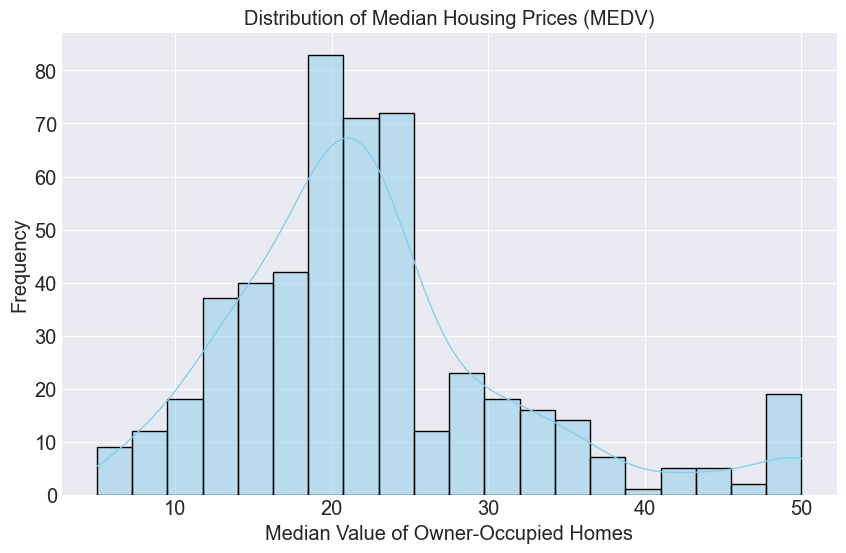

In [7]:
plt.figure(figsize=(10, 6))  # Set the figure size (optional)
sns.histplot(data_df['MEDV'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Median Housing Prices (MEDV)')
plt.xlabel('Median Value of Owner-Occupied Homes')
plt.ylabel('Frequency')
plt.show()


In [8]:
print ('Before: ', data_df.shape)
data_df = data_df[data_df['MEDV']<50].copy()
print('After:',data_df.shape)

Before:  (506, 14)
After: (490, 14)


In [9]:
outlier_list = []
    
for count, col in enumerate(data_df.columns):
    Q1 = np.percentile(data_df[col],25)
    Q3 = np.percentile(data_df[col],75) 
    outlier_dist = (Q3-Q1)*1.5 #IQR
    outlier_list.extend(data_df[data_df[col]<Q1 - outlier_dist].index)
    outlier_list.extend(data_df[data_df[col]>Q3 + outlier_dist].index)    
    
len(outlier_list)    

307

In [10]:
outlier_list = Counter(outlier_list)
outlier_list

Counter({412: 4,
         414: 4,
         367: 3,
         374: 3,
         384: 3,
         438: 3,
         203: 3,
         282: 3,
         262: 3,
         373: 2,
         386: 2,
         387: 2,
         399: 2,
         404: 2,
         406: 2,
         407: 2,
         409: 2,
         410: 2,
         411: 2,
         413: 2,
         415: 2,
         416: 2,
         417: 2,
         418: 2,
         419: 2,
         420: 2,
         422: 2,
         425: 2,
         426: 2,
         427: 2,
         429: 2,
         431: 2,
         434: 2,
         435: 2,
         436: 2,
         437: 2,
         444: 2,
         445: 2,
         454: 2,
         190: 2,
         196: 2,
         197: 2,
         198: 2,
         202: 2,
         256: 2,
         274: 2,
         276: 2,
         277: 2,
         286: 2,
         291: 2,
         351: 2,
         352: 2,
         353: 2,
         354: 2,
         355: 2,
         152: 2,
         154: 2,
         155: 2,
         160: 

In [11]:
print('Before: ', data_df.shape)
data_df = data_df.drop([412,414], axis = 0).copy()
data_df.reset_index(inplace = True, drop = True)
print('After: ', data_df.shape)

Before:  (490, 14)
After:  (488, 14)


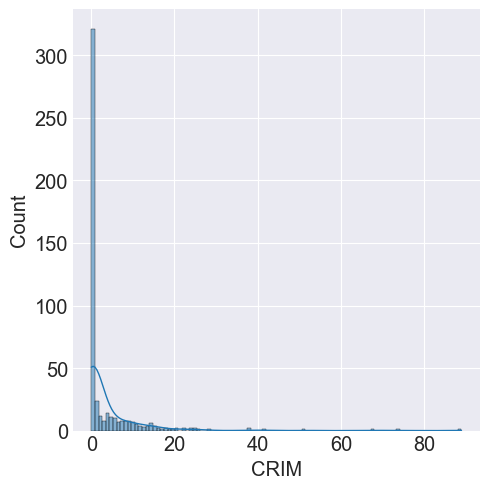

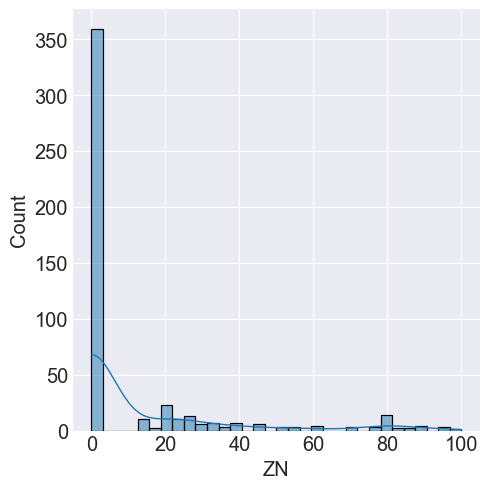

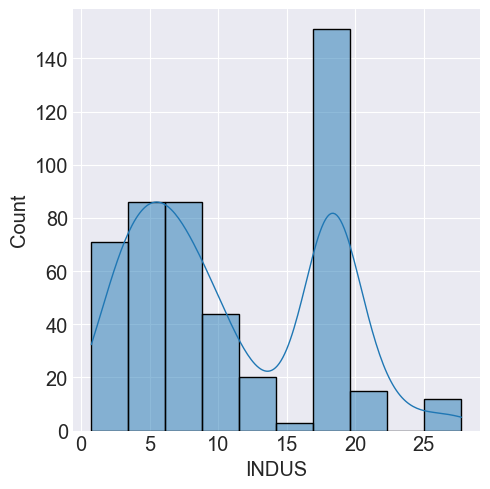

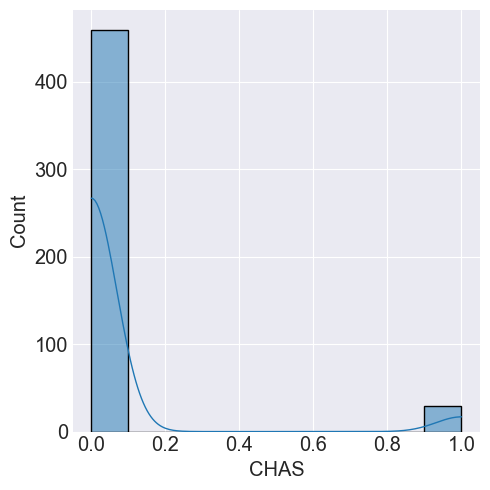

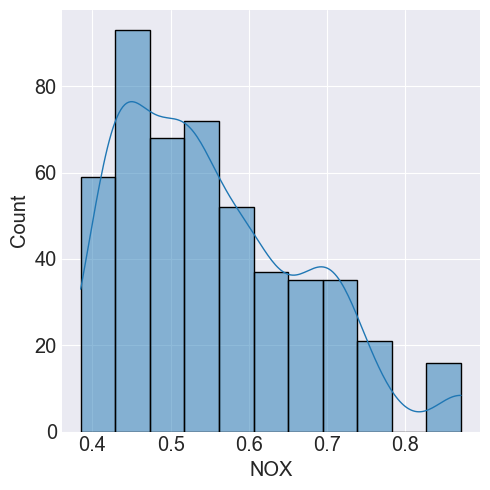

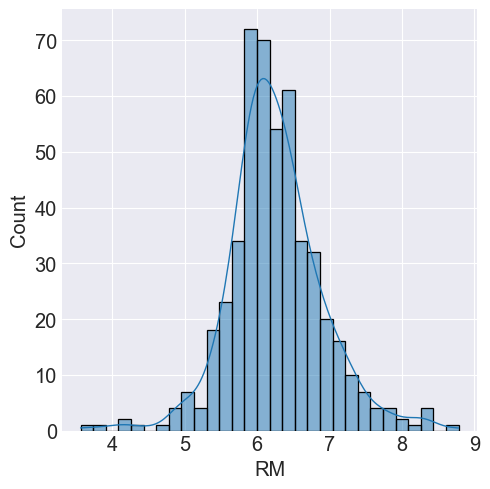

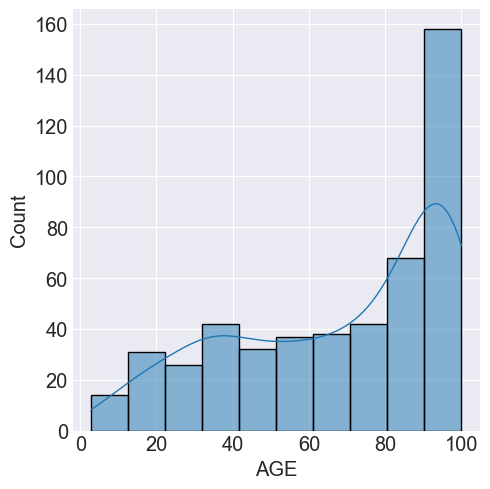

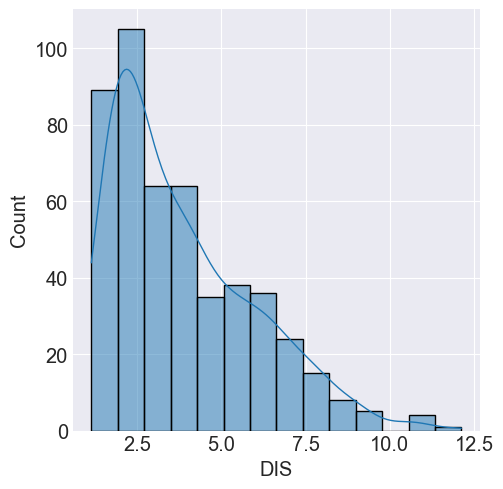

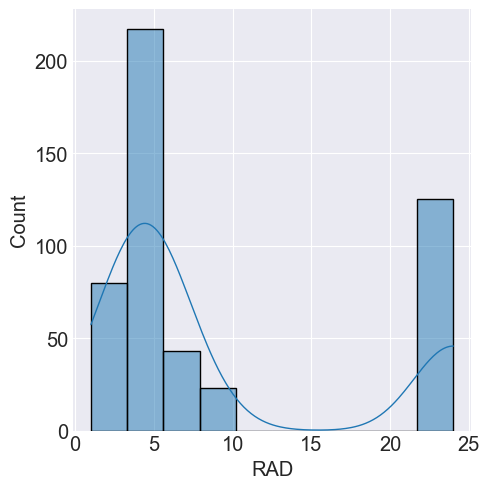

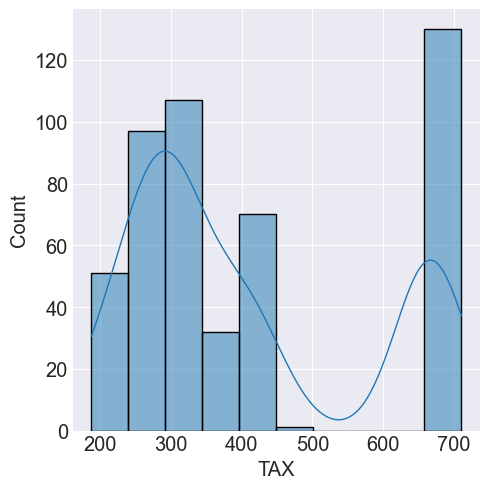

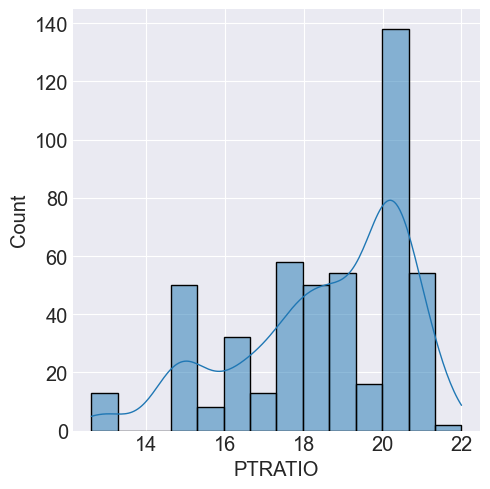

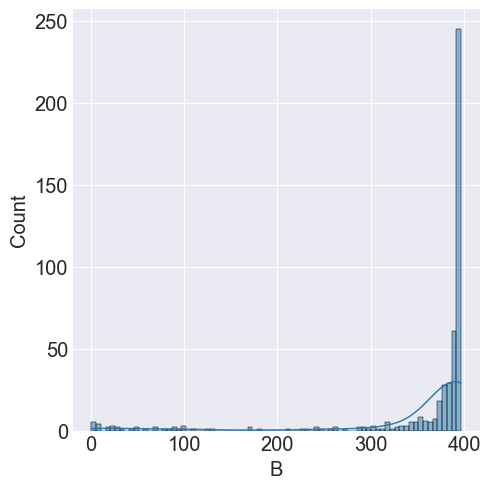

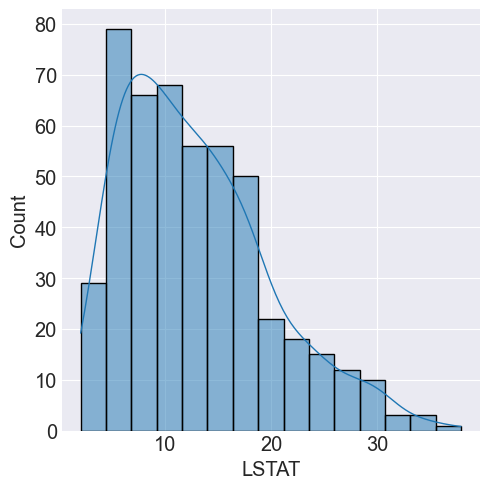

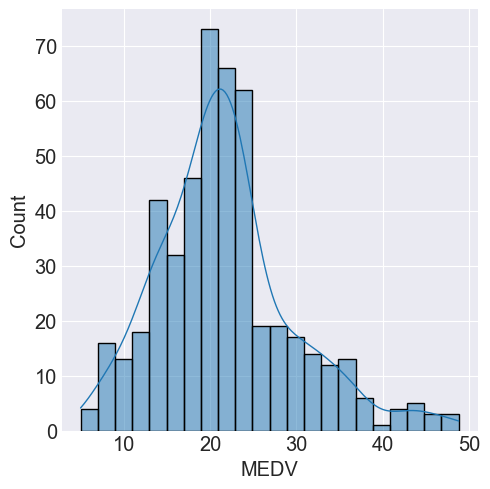

In [12]:
 for count, col in enumerate(data_df.columns):
    sns.displot(data = data_df, x = col, kde = True)

<Axes: >

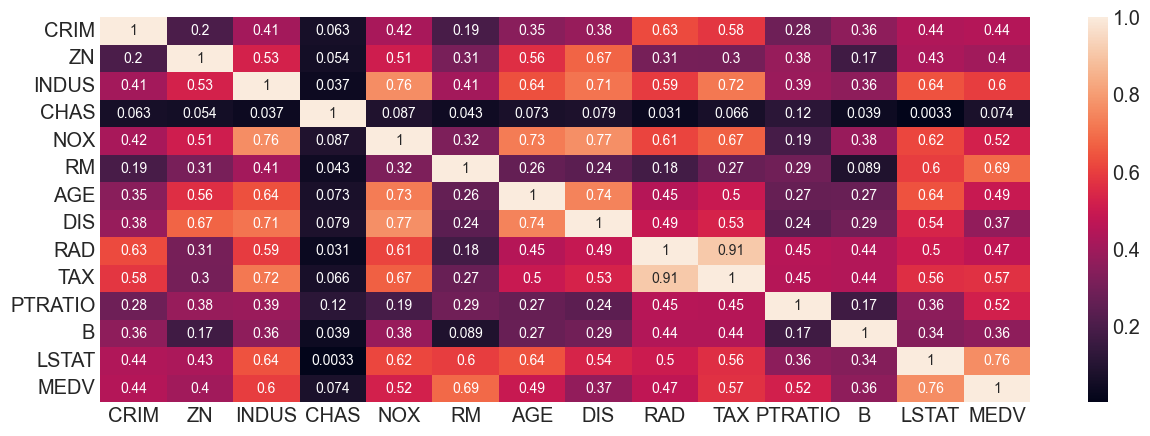

In [13]:
plt.figure()

sns.heatmap(data_df.corr().abs(),annot = True)

In [14]:
col_sel = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'RAD', 'TAX', 'PTRATIO', 'LSTAT']

features_df = data_df[col_sel].copy()

target = data_df['MEDV']

print(features_df.shape, target.shape)

(488, 10) (488,)


In [15]:
features_df.head()

,CRIM,ZN,INDUS,NOX,...,RAD,TAX,PTRATIO,LSTAT
0,6.32e-03,18.0,2.31,0.54,...,1.0,296.0,15.3,4.98
1,2.73e-02,0.0,7.07,0.47,...,2.0,242.0,17.8,9.14
2,2.73e-02,0.0,7.07,0.47,...,2.0,242.0,17.8,4.03
3,3.24e-02,0.0,2.18,0.46,...,3.0,222.0,18.7,2.94
4,6.91e-02,0.0,2.18,0.46,...,3.0,222.0,18.7,5.33


In [16]:
scaler = MinMaxScaler()

features_df = pd.DataFrame(data = scaler.fit_transform(features_df), columns = col_sel)
features_df 

,CRIM,ZN,INDUS,NOX,...,RAD,TAX,PTRATIO,LSTAT
0,0.00e+00,0.18,0.06,0.31,...,0.00,0.21,0.29,0.08
1,2.36e-04,0.00,0.23,0.17,...,0.04,0.10,0.55,0.20
2,2.36e-04,0.00,0.23,0.17,...,0.04,0.10,0.55,0.06
3,2.93e-04,0.00,0.05,0.15,...,0.09,0.07,0.65,0.03
4,7.05e-04,0.00,0.05,0.15,...,0.09,0.07,0.65,0.09
...,...,...,...,...,...,...,...,...,...
483,6.33e-04,0.00,0.41,0.39,...,0.00,0.16,0.89,0.21
484,4.38e-04,0.00,0.41,0.39,...,0.00,0.16,0.89,0.20
485,6.12e-04,0.00,0.41,0.39,...,0.00,0.16,0.89,0.10
486,1.16e-03,0.00,0.41,0.39,...,0.00,0.16,0.89,0.13


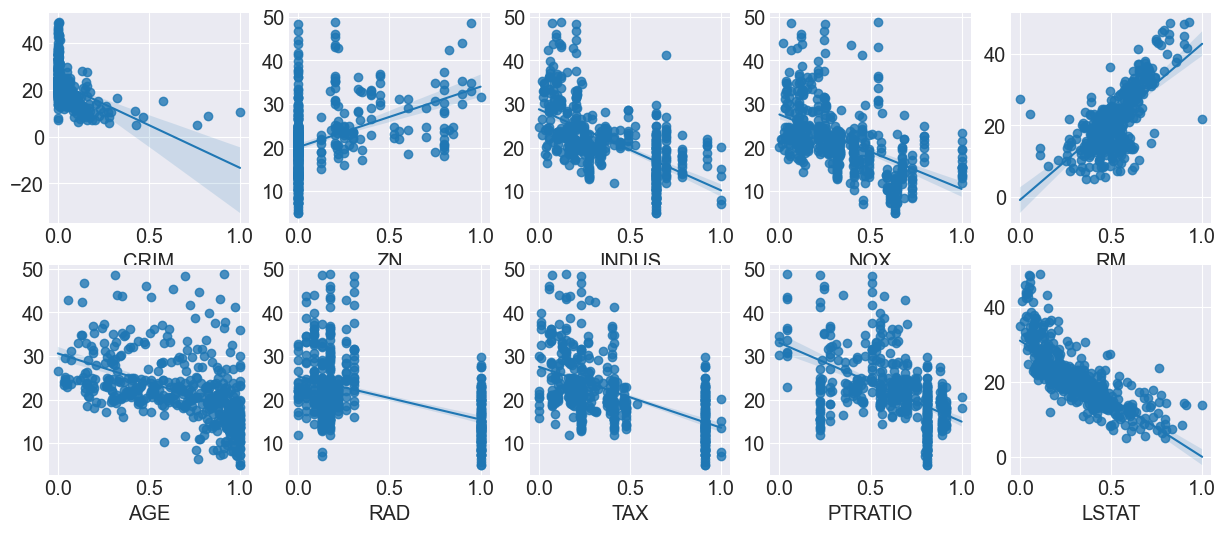

In [17]:
fig, axes = plt.subplots(ncols = 5, nrows = 2, figsize = (15,6))
axes = axes.ravel()

for count, col in enumerate(col_sel):
    sns.regplot(x = features_df[col], y = target.to_numpy(), ax = axes[count])

### Eliminate Skew 

In [18]:
target

0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
483    22.4
484    20.6
485    23.9
486    22.0
487    11.9
Name: MEDV, Length: 488, dtype: float64

In [19]:
y = np.log1p(target.to_numpy())

for col in features_df.columns:
    
    skw = features_df[col].skew()
    
    print(f'column {col}: Skew: {skw:7.4f}')
    
    if np.abs(skw) > 0.3: #adress if skew is more than 0.3
        
        print('transforming colum:',col)
        
        features_df[col] = np.log1p(features_df[col])

column CRIM: Skew:  5.3802
transforming colum: CRIM
column ZN: Skew:  2.2348
transforming colum: ZN
column INDUS: Skew:  0.3314
transforming colum: INDUS
column NOX: Skew:  0.7616
transforming colum: NOX
column RM: Skew:  0.2215
column AGE: Skew: -0.5828
transforming colum: AGE
column RAD: Skew:  1.0311
transforming colum: RAD
column TAX: Skew:  0.6932
transforming colum: TAX
column PTRATIO: Skew: -0.8175
transforming colum: PTRATIO
column LSTAT: Skew:  0.8605
transforming colum: LSTAT


In [20]:
reg = LinearRegression()

kf = KFold(n_splits=10) #Hard Coded

scores = cross_val_score(reg, features_df.to_numpy(), y, cv=kf, scoring='neg_mean_squared_error')

scores

array([-0.015, -0.014, -0.026, -0.026, -0.03 , -0.021, -0.02 , -0.109,
       -0.07 , -0.041])

In [21]:
scores.mean(),scores.std()

(-0.037237007292657824, 0.028404458448644733)

In [22]:
reg.fit(features_df.to_numpy(), y)
y_pred = reg.predict(features_df.to_numpy())

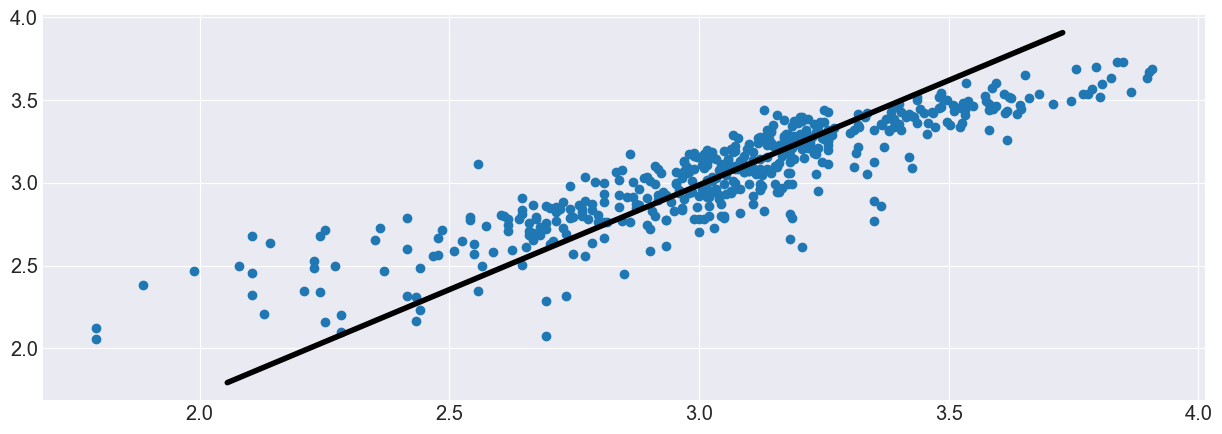

In [23]:
plt.scatter(y, y_pred)
plt.plot([y_pred.min(), y_pred.max()],[y.min(),y.max()],c='black',lw=4);

### Logistic Regression

In [24]:
x, y = make_moons(n_samples=N_SAMPLE, noise = NOISE, shuffle=True, random_state=RANDOM_STATE)

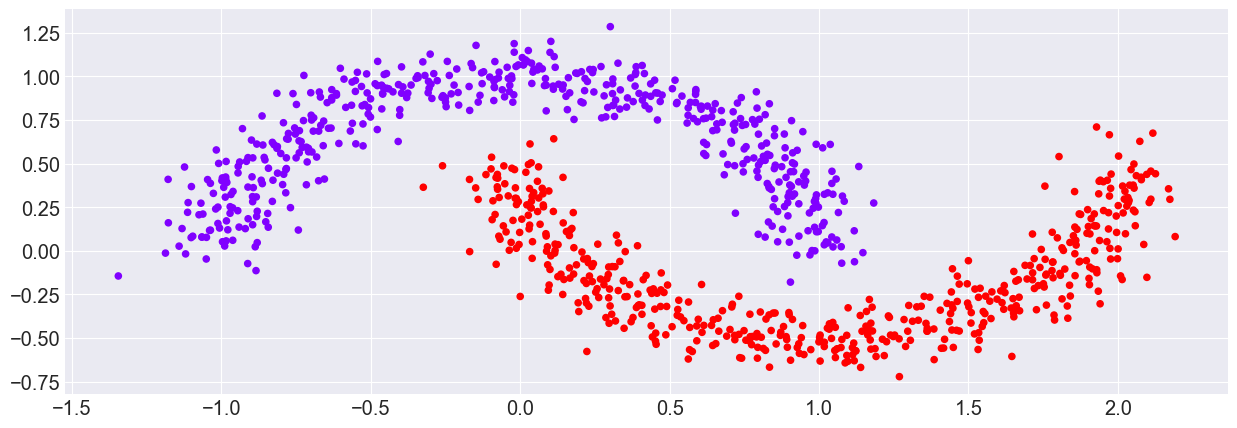

In [25]:
plt.scatter(x[:,0],x[:,1],s=20,c=y,cmap=CMAP)

In [26]:
clf = LogisticRegression(penalty = None, random_state = RANDOM_STATE)

clf.fit(x,y)

y_pred = clf.predict(x[:2, :])
y_pred

array([0, 0], dtype=int64)

In [27]:
clf.predict_proba(x[:2,:])

array([[0.951, 0.049],
       [0.99 , 0.01 ]])

In [28]:
clf.predict_proba(x[:3,:])

array([[0.951, 0.049],
       [0.99 , 0.01 ],
       [0.32 , 0.68 ]])

In [29]:
clf.score(x,y)

0.881

In [30]:
def fn_plot_decision_boundary(clf_, x,y):
    fig, ax = plt.subplots(figsize = (12,8))

    dm = 0.01

    x_min, x_max = x[:,0].min() - 0.5, x[:,0].max()+0.5 
    y_min, y_max = x[:,1].min() - 0.5, x[:,0].max()+0.5

    xx,yy = np.meshgrid(np.arange(x_min,x_max,dm),np.arange(y_min,y_max,dm)) 
    zz = np.c_[xx.ravel(),yy.ravel()]
    y_pred = clf.predict(zz)
    z = np.array(y_pred).reshape(xx.shape)
    ax.contourf(xx,yy,z,alpha = 0.6, cmap=CMAP)
    ax.scatter(x[:,0], x[:,1], c = y, s = 10,marker='*',cmap=plt.cm.coolwarm)

In [31]:
clf = LogisticRegression(penalty = None, multi_class = 'ovr', random_state = RANDOM_STATE)

In [32]:
iris_file = os.path.join(inpDir, 'iris.csv')
iris_features = ['sepal length',
                'sepal width',
                'petal length',
                'petal width','target']     # create list containing all column names
iris_df = pd.read_csv(iris_file,
                      skiprows = 1,        # ignore first row
                      sep = ',',            # using separator as ,
                      header = None,       # no column names
                      names = iris_features)       # use these column names
iris_df.head()

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [37]:
x_train, x_test, y_train, y_test = train_test_split(features, labels,
                                                   stratify=labels,
                                                   test_size=TEST_SIZE,
                                                   random_state=RANDOM_STATE)
x_train, x_test, y_train, y_test

NameError: name 'features' is not defined